# Set up

In [1]:
from footbot.data import utils
import pandas as pd
import patsy
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)

# Getting data

In [3]:
client = utils.set_up_bigquery(secrets_path='../secrets/service_account.json')

In [4]:
sql = \
'''
SELECT
  event,
  element,
  total_points,
  safe_web_name,
  element_type,
  cluster,
  team,
  value,
  total_points_per_minute_previous_season,
  goals_scored_per_minute_previous_season,
  assists_per_minute_previous_season,
  clean_sheets_per_minute_previous_season,
  goals_conceded_per_minute_previous_season,
  own_goals_per_minute_previous_season,
  penalties_saved_per_minute_previous_season,
  penalties_missed_per_minute_previous_season,
  yellow_cards_per_minute_previous_season,
  red_cards_per_minute_previous_season,
  saves_per_minute_previous_season,
  bonus_per_minute_previous_season,
  bps_per_minute_previous_season,
  opponent_team,
  was_home,
  was_sunday,
  was_weekday,
  was_late,
  was_early,
  rolling_avg_total_points_element,
  rolling_avg_minutes_element,
  rolling_avg_goals_scored_element,
  rolling_avg_assists_element,
  rolling_avg_clean_sheets_element,
  rolling_avg_goals_conceded_element,
  rolling_avg_own_goals_element,
  rolling_avg_penalties_saved_element,
  rolling_avg_penalties_missed_element,
  rolling_avg_yellow_cards_element,
  rolling_avg_red_cards_element,
  rolling_avg_saves_element,
  rolling_avg_bonus_element,
  rolling_avg_bps_element,
  rolling_avg_total_points_element_p1,
  rolling_avg_total_points_element_p2,
  rolling_avg_total_points_element_p3,
  rolling_avg_total_points_element_p4,
  rolling_avg_total_points_element_p5,
  rolling_avg_total_points_element_p10,
  rolling_avg_goals_scored_element_p1,
  rolling_avg_goals_scored_element_p2,
  rolling_avg_goals_scored_element_p3,
  rolling_avg_goals_scored_element_p4,
  rolling_avg_goals_scored_element_p5,
  rolling_avg_goals_scored_element_p10,
  rolling_avg_assists_element_p1,
  rolling_avg_assists_element_p2,
  rolling_avg_assists_element_p3,
  rolling_avg_assists_element_p4,
  rolling_avg_assists_element_p5,
  rolling_avg_assists_element_p10,
  rolling_avg_clean_sheets_element_p1,
  rolling_avg_clean_sheets_element_p2,
  rolling_avg_clean_sheets_element_p3,
  rolling_avg_clean_sheets_element_p4,
  rolling_avg_clean_sheets_element_p5,
  rolling_avg_clean_sheets_element_p10,
  rolling_avg_goals_conceded_element_p1,
  rolling_avg_goals_conceded_element_p2,
  rolling_avg_goals_conceded_element_p3,
  rolling_avg_goals_conceded_element_p4,
  rolling_avg_goals_conceded_element_p5,
  rolling_avg_goals_conceded_element_p10,
  rolling_avg_saves_element_p1,
  rolling_avg_saves_element_p2,
  rolling_avg_saves_element_p3,
  rolling_avg_saves_element_p4,
  rolling_avg_saves_element_p5,
  rolling_avg_saves_element_p10,
  rolling_avg_minutes_element_p1,
  rolling_avg_minutes_element_p2,
  rolling_avg_minutes_element_p3,
  rolling_avg_minutes_element_p4,
  rolling_avg_minutes_element_p5,
  rolling_avg_minutes_element_p10,
  expected_total_points_against_opponent_team_element_type,
  expected_minutes_against_opponent_team_element_type,
  expected_goals_scored_against_opponent_team_element_type,
  expected_assists_against_opponent_team_element_type,
  expected_clean_sheets_against_opponent_team_element_type,
  expected_goals_conceded_against_opponent_team_element_type,
  expected_own_goals_against_opponent_team_element_type,
  expected_penalties_saved_against_opponent_team_element_type,
  expected_penalties_missed_against_opponent_team_element_type,
  expected_yellow_cards_against_opponent_team_element_type,
  expected_red_cards_against_opponent_team_element_type,
  expected_saves_against_opponent_team_element_type,
  expected_bonus_against_opponent_team_element_type,
  expected_bps_against_opponent_team_element_type,
  rolling_avg_squad,
  rolling_avg_first_team,
  rolling_avg_vice_or_captain,
  rolling_avg_squad_p1,
  rolling_avg_first_team_p1,
  rolling_avg_vice_or_captain_p1
FROM
  `footbot-001.fpl.element_gameweeks_features_1819_v01`
'''

In [5]:
# get dataframe
df_all = client.query(sql).to_dataframe()

In [6]:
last_train_event = 25
last_test_event = 38
element_filter_field = 'rolling_avg_total_points_element'
element_filter_value = 1

In [7]:
# filter out elements
element_filter_df = df_all[df_all['event'] == last_train_event + 1]

element_filter = element_filter_df[
    element_filter_df[element_filter_field] > element_filter_value
]['element'].values

df = df_all[
    (df_all['event'] <= last_test_event)
    & (df_all['element'].isin(element_filter))
]

# impute missing values by element type
df = pd.concat([
    df[df['element_type'] == i].fillna(
        df[
            (df['event'] <= last_train_event)
            & (df['element_type'] == i)
        ].mean()).fillna(0)
    for i in range(1, 5)
])

In [8]:
df = df[df['element_type'] == 1]

# Modelling data

## Splitting data

In [9]:
test_fold = [-1 if i <= last_train_event else 0 for i in df['event']]
ps = PredefinedSplit(test_fold)

In [10]:
for train_index, test_index in ps.split():
    df_train, df_test = \
    df.copy().iloc[train_index], df.copy().iloc[test_index]

## Scaling data

In [11]:
list(df.columns)

['event',
 'element',
 'total_points',
 'safe_web_name',
 'element_type',
 'cluster',
 'team',
 'value',
 'total_points_per_minute_previous_season',
 'goals_scored_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'penalties_saved_per_minute_previous_season',
 'penalties_missed_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'red_cards_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'opponent_team',
 'was_home',
 'was_sunday',
 'was_weekday',
 'was_late',
 'was_early',
 'rolling_avg_total_points_element',
 'rolling_avg_minutes_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_assists_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_own_goals_element',
 'rolling_a

In [12]:
scaled_feature_cols = [
    i for i in df.columns if i not in [
        'total_points',
        'goals_scored',
        'assists',
        'clean_sheets',
        'goals_conceded',
        'saves',
        'minutes',
        'element',
        'safe_web_name',
        'element_type',
        'cluster',
        'team',
        'event',
        'fixture',
        'opponent_team',
        'was_home',
        'was_sunday',
        'was_weekday',
        'was_late',
        'was_early',
    ]
]

scaled_feature_cols

['value',
 'total_points_per_minute_previous_season',
 'goals_scored_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'penalties_saved_per_minute_previous_season',
 'penalties_missed_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'red_cards_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'rolling_avg_total_points_element',
 'rolling_avg_minutes_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_assists_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_own_goals_element',
 'rolling_avg_penalties_saved_element',
 'rolling_avg_penalties_missed_element',
 'rolling_avg_yellow_cards_element',
 'rolling_avg_red_cards_element',
 'rolling_avg_saves_element',
 'rolling_avg

In [13]:
scaled_df_train = df_train.copy()
scaled_df_test = df_test.copy()
scaled_df = df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

df_train[scaled_feature_cols] = scaled_df_train
df_test[scaled_feature_cols] = scaled_df_test
df[scaled_feature_cols] = scaled_df

## Building model

In [14]:
formula = \
'''
total_points
~ C(element_type)
+ C(opponent_team)
+ C(team)
+ C(was_home)
+ C(was_sunday)
+ C(was_weekday)
+ C(was_late)
+ C(was_early)
+
'''  + ' + '.join(scaled_feature_cols)

In [15]:
print(formula)


total_points
~ C(element_type)
+ C(opponent_team)
+ C(team)
+ was_home
+ was_sunday
+ was_weekday
+ was_late
+ was_early
+
value + total_points_per_minute_previous_season + goals_scored_per_minute_previous_season + assists_per_minute_previous_season + clean_sheets_per_minute_previous_season + goals_conceded_per_minute_previous_season + own_goals_per_minute_previous_season + penalties_saved_per_minute_previous_season + penalties_missed_per_minute_previous_season + yellow_cards_per_minute_previous_season + red_cards_per_minute_previous_season + saves_per_minute_previous_season + bonus_per_minute_previous_season + bps_per_minute_previous_season + rolling_avg_total_points_element + rolling_avg_minutes_element + rolling_avg_goals_scored_element + rolling_avg_assists_element + rolling_avg_clean_sheets_element + rolling_avg_goals_conceded_element + rolling_avg_own_goals_element + rolling_avg_penalties_saved_element + rolling_avg_penalties_missed_element + rolling_avg_yellow_cards_element + r

In [16]:
y, X = patsy.dmatrices(formula, df, return_type='matrix')

In [17]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

### Least squares

In [18]:
ls_estimator = LinearRegression()

ls_selector = RFECV(
    ls_estimator,
    step=1,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

ls_selector.fit(
    np.asarray(X),
    np.asarray(y).ravel()
)

Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [19]:
sum(ls_selector.support_)

24

In [20]:
-ls_selector.grid_scores_[-1]

9.733949397884217

In [21]:
ls_sel_cols = list(pd.Series(X.design_info.column_names)[ls_selector.support_])
ls_sel_cols

['C(team)[T.bournemouth]',
 'C(team)[T.brighton]',
 'C(team)[T.burnley]',
 'C(team)[T.everton]',
 'C(team)[T.huddersfield]',
 'C(team)[T.leicester]',
 'C(team)[T.liverpool]',
 'C(team)[T.man city]',
 'C(team)[T.newcastle]',
 'C(team)[T.southampton]',
 'C(team)[T.spurs]',
 'C(team)[T.watford]',
 'C(team)[T.west ham]',
 'total_points_per_minute_previous_season',
 'goals_scored_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'penalties_saved_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season']

In [22]:
ls_X_sel = X[:,ls_selector.support_]
ls_X_train_sel = X_train[:,ls_selector.support_]
ls_X_test_sel = X_test[:,ls_selector.support_]

In [23]:
ls_estimator.fit(ls_X_train_sel, y_train)
pd.DataFrame(
    list(zip(ls_sel_cols, list(ls_estimator.coef_[0]))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
8,C(team)[T.newcastle],4.888265e+13
2,C(team)[T.burnley],2.884547e+13
23,bps_per_minute_previous_season,2.280261e+13
20,yellow_cards_per_minute_previous_season,2.184870e+13
7,C(team)[T.man city],2.145087e+13
13,total_points_per_minute_previous_season,2.018902e+13
3,C(team)[T.everton],1.990861e+13
11,C(team)[T.watford],1.828754e+13
18,own_goals_per_minute_previous_season,8.339863e+12
21,saves_per_minute_previous_season,7.603810e+12


### Ridge

In [35]:
ridge_estimator = Ridge(alpha=60)

ridge_selector = RFECV(
    ridge_estimator,
    step=1,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

ridge_selector.fit(
    np.asarray(X),
    np.asarray(y).ravel()
)

Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [36]:
sum(ridge_selector.support_)

73

In [37]:
-ridge_selector.grid_scores_[-1]

6.161518953490471

In [38]:
ridge_sel_cols = list(pd.Series(X.design_info.column_names)[ridge_selector.support_])
ridge_sel_cols

['C(opponent_team)[T.brighton]',
 'C(opponent_team)[T.burnley]',
 'C(opponent_team)[T.cardiff]',
 'C(opponent_team)[T.crystal palace]',
 'C(opponent_team)[T.everton]',
 'C(opponent_team)[T.fulham]',
 'C(opponent_team)[T.huddersfield]',
 'C(opponent_team)[T.leicester]',
 'C(opponent_team)[T.liverpool]',
 'C(opponent_team)[T.man city]',
 'C(opponent_team)[T.man utd]',
 'C(opponent_team)[T.newcastle]',
 'C(opponent_team)[T.southampton]',
 'C(opponent_team)[T.spurs]',
 'C(opponent_team)[T.watford]',
 'C(opponent_team)[T.west ham]',
 'C(team)[T.brighton]',
 'C(team)[T.cardiff]',
 'C(team)[T.fulham]',
 'C(team)[T.liverpool]',
 'C(team)[T.man utd]',
 'C(team)[T.west ham]',
 'was_home',
 'was_sunday',
 'was_weekday',
 'was_late',
 'value',
 'total_points_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'rolling_avg_total_points_element',
 'rolling_avg_minute

In [39]:
ridge_X_sel = X[:,ridge_selector.support_]
ridge_X_train_sel = X_train[:,ridge_selector.support_]
ridge_X_test_sel = X_test[:,ridge_selector.support_]

In [40]:
ridge_estimator.fit(ridge_X_train_sel, y_train)
pd.DataFrame(
    list(zip(ridge_sel_cols, list(ridge_estimator.coef_[0]))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
55,rolling_avg_minutes_element_p1,0.450874
44,rolling_avg_assists_element_p10,0.341067
19,C(team)[T.liverpool],0.336723
35,rolling_avg_penalties_saved_element,0.273732
3,C(opponent_team)[T.crystal palace],0.268627
52,rolling_avg_saves_element_p3,0.255833
2,C(opponent_team)[T.cardiff],0.249350
5,C(opponent_team)[T.fulham],0.241623
6,C(opponent_team)[T.huddersfield],0.228765
12,C(opponent_team)[T.southampton],0.224634


### Lasso

In [41]:
lasso_estimator = Lasso(alpha=0.02)

lasso_selector = RFECV(
    lasso_estimator,
    step=1,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

lasso_selector.fit(
    np.asarray(X),
    np.asarray(y).ravel()
)

Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Lasso(alpha=0.02, copy_X=True, fit_intercept=True,
                      max_iter=1000, normalize=False, positive=False,
                      precompute=False, random_state=None, selection='cyclic',
                      tol=0.0001, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [42]:
sum(lasso_selector.support_)

46

In [43]:
-lasso_selector.grid_scores_[-1]

6.150846641439164

In [44]:
lasso_sel_cols = list(pd.Series(X.design_info.column_names)[lasso_selector.support_])
lasso_sel_cols

['C(opponent_team)[T.brighton]',
 'C(opponent_team)[T.cardiff]',
 'C(opponent_team)[T.fulham]',
 'C(opponent_team)[T.huddersfield]',
 'C(opponent_team)[T.liverpool]',
 'C(opponent_team)[T.man city]',
 'C(opponent_team)[T.man utd]',
 'C(opponent_team)[T.newcastle]',
 'C(opponent_team)[T.spurs]',
 'C(team)[T.fulham]',
 'C(team)[T.liverpool]',
 'was_home',
 'was_sunday',
 'was_late',
 'value',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_penalties_saved_element',
 'rolling_avg_bonus_element',
 'rolling_avg_total_points_element_p2',
 'rolling_avg_total_points_element_p3',
 'rolling_avg_assists_element_p1',
 'rolling_avg_assists_element_p2',
 'rolling_avg_assists_element_p10',
 'rolling_avg_clean_sheets_element_p3',
 'rolling_avg_goals_conceded_el

In [45]:
lasso_X_sel = X[:,lasso_selector.support_]
lasso_X_train_sel = X_train[:,lasso_selector.support_]
lasso_X_test_sel = X_test[:,lasso_selector.support_]

In [46]:
lasso_estimator.fit(lasso_X_train_sel, y_train)
pd.DataFrame(
    list(zip(lasso_sel_cols, list(lasso_estimator.coef_))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
10,C(team)[T.liverpool],1.105419
36,rolling_avg_minutes_element_p1,0.757216
21,rolling_avg_goals_conceded_element,0.501365
1,C(opponent_team)[T.cardiff],0.382258
28,rolling_avg_assists_element_p10,0.377796
25,rolling_avg_total_points_element_p3,0.352600
22,rolling_avg_penalties_saved_element,0.250418
3,C(opponent_team)[T.huddersfield],0.207661
39,expected_penalties_saved_against_opposition_team_element_type,0.205230
2,C(opponent_team)[T.fulham],0.196706


## Tuning model

### GP tuner

#### Ridge

In [24]:
ridge_space  = [
    Real(10**-8, 10**5, 'log-uniform', name='alpha')
]

In [47]:
ridge_gp_model = Ridge()

@use_named_args(ridge_space)
def ridge_objective(**params):
    ridge_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            ridge_gp_model,
#             np.asarray(X),
            np.asarray(ridge_X_sel),
            np.asarray(y).ravel(),
            cv=ps,
            scoring="neg_mean_squared_error"))

In [48]:
ridge_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    ridge_res_gp = gp_minimize(
        ridge_objective,
        ridge_space,
        n_calls=50,
        n_jobs=-1,
        verbose=2
    )
    ridge_res_gp_arr.append(ridge_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0296
Function value obtained: 6.4446
Current minimum: 6.4446
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0056
Function value obtained: 7.4192
Current minimum: 6.4446
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0085
Function value obtained: 6.4446
Current minimum: 6.4446
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0079
Function value obtained: 6.4446
Current minimum: 6.4446
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0068
Function value obtained: 6.4446
Current minimum: 6.4446
Iteration 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.0452
Function value obtained: 5.9911
Current minimum: 5.9911
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.0073
Function value obtained: 5.9911
Current minimum: 5.9911
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.1989
Function value obtained: 5.9911
Current minimum: 5.9911
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.5466
Function value obtained: 5.9987
Current minimum: 5.9911
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.0795
Function value obtained: 6.0027
Current minimum: 5.9911
Iteration No: 46 started. Sea

In [49]:
for i in ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in ridge_res_gp_arr:
    print(i.x)

5.99112734114226


[29.004537690069544]


In [50]:
ridge_estimator = Ridge(alpha=ridge_res_gp_arr[0].x[0])
ridge_estimator.fit(X_train, y_train)
pd.DataFrame(
    list(zip(X.design_info.column_names, list(ridge_estimator.coef_[0]))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
108,rolling_avg_minutes_element_p1,0.597308
30,C(team)[T.liverpool],0.586228
89,rolling_avg_assists_element_p10,0.532918
6,C(opponent_team)[T.crystal palace],0.447143
15,C(opponent_team)[T.southampton],0.404646
4,C(opponent_team)[T.cardiff],0.387034
8,C(opponent_team)[T.fulham],0.377986
104,rolling_avg_saves_element_p3,0.365436
9,C(opponent_team)[T.huddersfield],0.356625
73,rolling_avg_total_points_element_p2,0.353673


#### Lasso

In [29]:
lasso_space  = [
    Real(10**-8, 10**3, 'log-uniform', name='alpha')
]

In [51]:
lasso_gp_model = Lasso()

@use_named_args(lasso_space)
def lasso_objective(**params):
    lasso_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lasso_gp_model,
#             np.asarray(X),
            np.asarray(lasso_X_sel),
            np.asarray(y).ravel(),
            cv=ps,
            scoring="neg_mean_squared_error"))

In [52]:
lasso_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    lasso_res_gp = gp_minimize(
        lasso_objective,
        lasso_space,
        n_calls=50,
        n_jobs=-1,
        verbose=2
    )
    lasso_res_gp_arr.append(lasso_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0323
Function value obtained: 6.1483
Current minimum: 6.1483
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0436
Function value obtained: 6.1483
Current minimum: 6.1483
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0114
Function value obtained: 6.1756
Current minimum: 6.1483
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0122
Function value obtained: 6.1312
Current minimum: 6.1312
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0271
Function value obtained: 6.1481
Current minimum: 6.1312
Iteration 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.1521
Function value obtained: 5.9455
Current minimum: 5.9449
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.9867
Function value obtained: 5.9454
Current minimum: 5.9449
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.1512
Function value obtained: 5.9455
Current minimum: 5.9449
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.1575
Function value obtained: 5.9454
Current minimum: 5.9449
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.1456
Function value obtained: 5.9454
Current minimum: 5.9449
Iteration No: 46 started. Sea

In [53]:
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

5.944933535632518


[0.012200587400679993]


In [54]:
lasso_estimator = Lasso(alpha=lasso_res_gp_arr[0].x[0])
lasso_estimator.fit(X_train, y_train)
lasso_gp_df = pd.DataFrame(
    list(zip(X.design_info.column_names, list(lasso_estimator.coef_))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

lasso_gp_df[abs(lasso_gp_df['weight']) > 0.001]

,feature,weight
30,C(team)[T.liverpool],1.662144
6,C(opponent_team)[T.crystal palace],0.916007
4,C(opponent_team)[T.cardiff],0.825236
15,C(opponent_team)[T.southampton],0.787601
108,rolling_avg_minutes_element_p1,0.746408
9,C(opponent_team)[T.huddersfield],0.728765
115,expected_minutes_against_opposition_team_element_type,0.686510
8,C(opponent_team)[T.fulham],0.632197
89,rolling_avg_assists_element_p10,0.607505
24,C(team)[T.chelsea],0.584363


# Evaluating model

## Least sqaures

In [55]:
ls_model = LinearRegression()

ls_model.fit(ls_X_train_sel, y_train.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [72]:
# get predictions for train set
ls_y_pred_train = ls_model.predict(ls_X_train_sel).flatten()

# calculate cross entropy loss for train set
ls_train_loss = (
    mean_absolute_error(y_train, ls_y_pred_train),
    mean_squared_error(y_train, ls_y_pred_train),
    r2_score(y_train, ls_y_pred_train)
)
ls_train_loss

(2.207831583550771, 8.236746163320726, 0.04989979385532384)

In [56]:
# get predictions for test set
ls_y_pred = ls_model.predict(ls_X_test_sel).flatten()

# calculate cross entropy loss for test set
ls_test_loss = (
    mean_absolute_error(y_test, ls_y_pred),
    mean_squared_error(y_test, ls_y_pred),
    r2_score(y_test, ls_y_pred)
)
ls_test_loss

(2.2067513935984326, 7.1766476069632485, 0.10023349605044429)

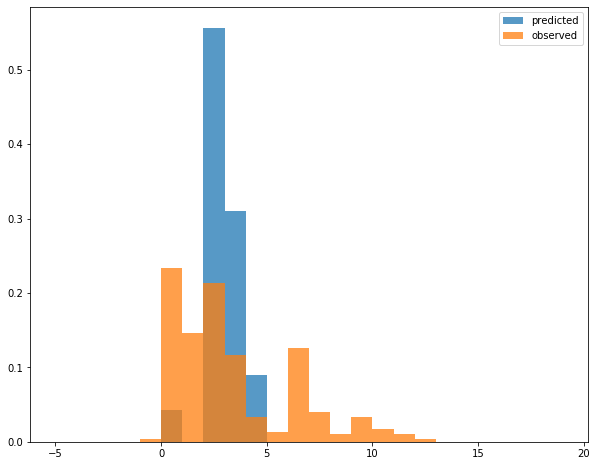

In [57]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(ls_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

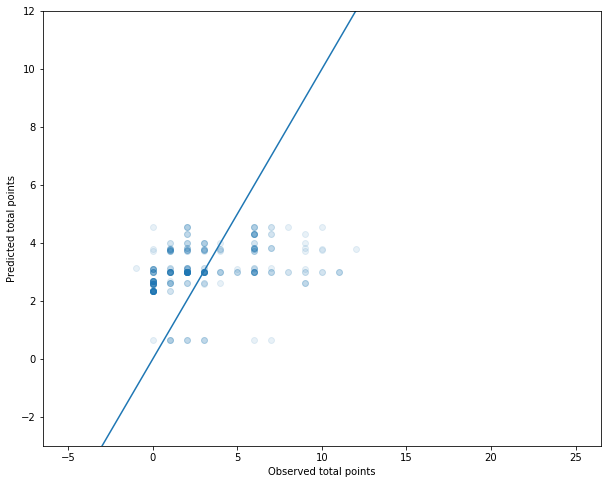

In [58]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(ls_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Ridge

In [59]:
ridge_model = Ridge(alpha=30)

ridge_model.fit(ridge_X_train_sel, y_train.ravel())

Ridge(alpha=30, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [73]:
# get predictions for train set
ridge_y_pred_train = ridge_model.predict(ridge_X_train_sel).flatten()

# calculate cross entropy loss for train set
ridge_train_loss = (
    mean_absolute_error(y_train, ridge_y_pred_train),
    mean_squared_error(y_train, ridge_y_pred_train),
    r2_score(y_train, ridge_y_pred_train)
)
ridge_train_loss

(1.9068701119895384, 6.340568487623779, 0.26862194030062436)

In [60]:
# get predictions for test set
ridge_y_pred = ridge_model.predict(ridge_X_test_sel).flatten()

# calculate cross entropy loss for test set
ridge_test_loss = (
    mean_absolute_error(y_test, ridge_y_pred),
    mean_squared_error(y_test, ridge_y_pred),
    r2_score(y_test, ridge_y_pred)
)
ridge_test_loss

(1.9417005473527051, 5.991213791271504, 0.24885632085985043)

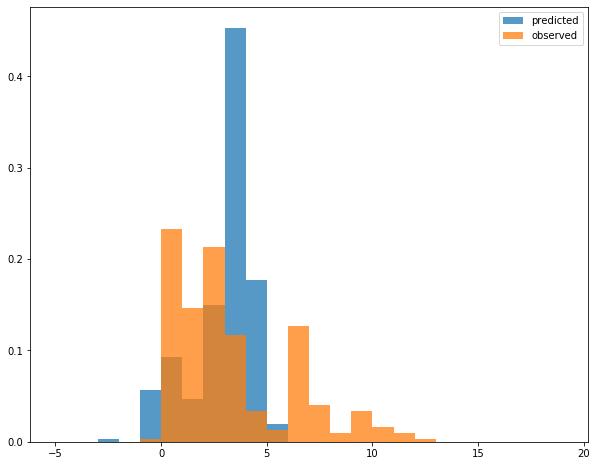

In [61]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(ridge_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

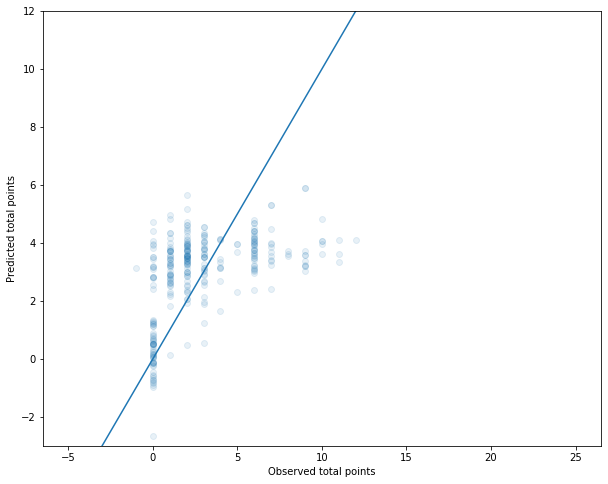

In [62]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(ridge_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Lasso

In [63]:
lasso_model = Ridge(alpha=0.01)

lasso_model.fit(lasso_X_train_sel, y_train.ravel())

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [71]:
# get predictions for train set
lasso_y_pred_train = lasso_model.predict(lasso_X_train_sel).flatten()

# calculate cross entropy loss for train set
lasso_train_loss = (
    mean_absolute_error(y_train, lasso_y_pred_train),
    mean_squared_error(y_train, lasso_y_pred_train),
    r2_score(y_train, lasso_y_pred_train)
)
lasso_train_loss

(1.9115198127943043, 6.357502195922126, 0.26666865444890064)

In [70]:
# get predictions for test set
lasso_y_pred_test = lasso_model.predict(lasso_X_test_sel).flatten()

# calculate cross entropy loss for test set
lasso_test_loss = (
    mean_absolute_error(y_test, lasso_y_pred_test),
    mean_squared_error(y_test, lasso_y_pred_test),
    r2_score(y_test, lasso_y_pred_test)
)
lasso_test_loss

(1.9820132331318343, 6.147924455276519, 0.22920884560321453)

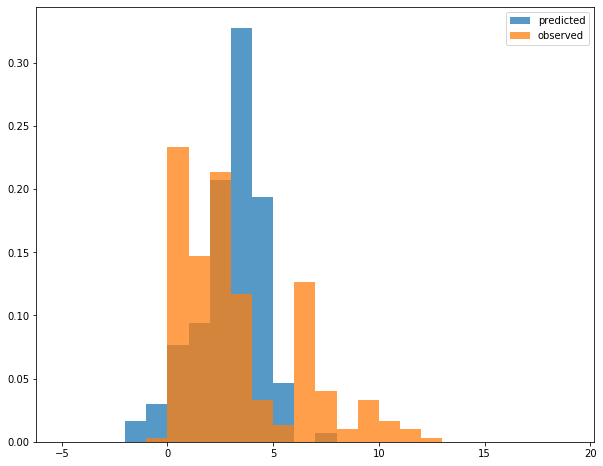

In [65]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lasso_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

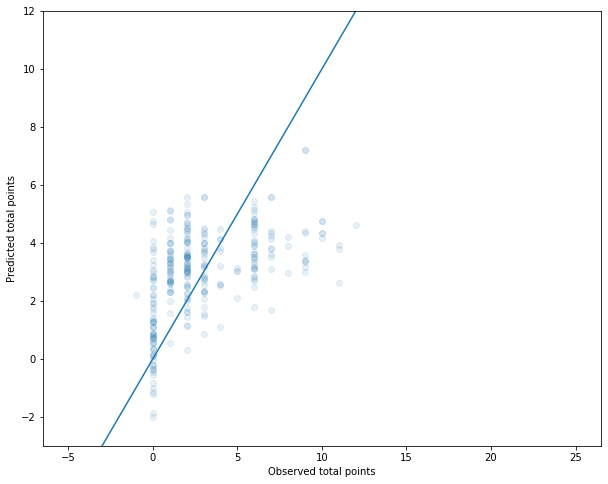

In [66]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(lasso_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [77]:
print('test loss')
print('test observations', len(y_test))
pd.DataFrame([
    ('Least squares', ls_test_loss[0], ls_test_loss[1], ls_test_loss[2]),
    ('Ridge', ridge_test_loss[0], ridge_test_loss[1], ridge_test_loss[2]),
    ('Lasso', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

test loss
test observations 300


,model,MAE,MSE,r2
0,Least squares,2.206751,7.176648,0.100233
1,Ridge,1.941701,5.991214,0.248856
2,Lasso,1.982013,6.147924,0.229209


In [78]:
print('train loss')
print('train observations', len(y_train))
pd.DataFrame([
    ('Least squares', ls_train_loss[0], ls_train_loss[1], ls_train_loss[2]),
    ('Ridge', ridge_train_loss[0], ridge_train_loss[1], ridge_train_loss[2]),
    ('Lasso', lasso_train_loss[0], lasso_train_loss[1], lasso_train_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

train loss
train observations 552


,model,MAE,MSE,r2
0,Least squares,2.207832,8.236746,0.049900
1,Ridge,1.906870,6.340568,0.268622
2,Lasso,1.911520,6.357502,0.266669


In [ ]:
print('test loss')
print('test observations', len(y_test))
pd.DataFrame([
    ('Least squares', ls_test_loss[0], ls_test_loss[1], ls_test_loss[2]),
    ('Ridge', ridge_test_loss[0], ridge_test_loss[1], ridge_test_loss[2]),
    ('Lasso', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

print('train loss')
print('train observations', len(y_train))
pd.DataFrame([
    ('Least squares', ls_train_loss[0], ls_train_loss[1], ls_train_loss[2]),
    ('Ridge', ridge_train_loss[0], ridge_train_loss[1], ridge_train_loss[2]),
    ('Lasso', lasso_train_loss[0], lasso_train_loss[1], lasso_train_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])